In [2]:
import numpy as np
import scipy
import pandas as pd

from scipy.optimize import minimize
from utils_carryover import *
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 16})

import matplotlib
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('legend', fontsize=13)
matplotlib.rcParams['savefig.dpi'] = 1200

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


direct effect only

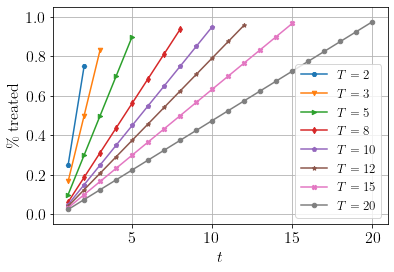

In [3]:
plt.figure()
markers = ['H', 'v', '>', 'd', 'p', '*', 'X', 'o']; T_list = [2,3,5,8,10,12,15,20]
for i in range(len(T_list)):
    T = T_list[i]
    plt.plot(range(1,T+1), [(2*t+1)/(2*T) for t in range(T)], marker=markers[i], label="$T="+str(T)+"$", markersize=4.5)
plt.xlabel("$t$"); plt.ylabel("$\%$ $\mathrm{treated}$");
plt.grid(True)
plt.legend()
plt.ylim((-0.05,1.05))
plt.savefig("../figures/two_way_fixed_effect_opt_treated_pct.pdf")

carryover effect: optimize trace

In [4]:
T = 10
result = dict(); result["$\ell="+str(0)+"$"] = [(2*t+1)/(2*T) for t in range(T)]
for lag in range(1, 6): # lag is the number of lags
    def carryover_fun(y, L=lag):
        # this function returns the objective function value
        H = theta1(y,L=L) - theta2(y,L=L)
        return -np.sum(np.diag(H))


    y0 = [((2*t+1)/T-1) for t in range(T)]
    bnds = tuple([(-1,1) for t in range(T)])
    cons = tuple([{'type': 'ineq', 'fun' : lambda y: y[t]-y[t-1]} for t in range(1,T)])
    res = scipy.optimize.minimize(carryover_fun, y0, constraints=cons, bounds=bnds)
    result["$\ell="+str(lag)+"$"] = (1+res.x)/2

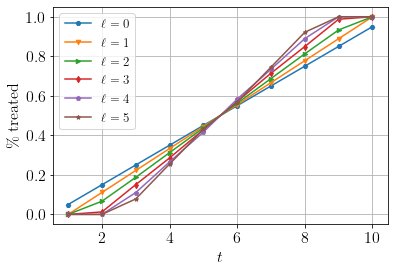

In [5]:
result_df = pd.DataFrame(result)
result_df['index'] = range(1, T+1)
result_df = result_df.set_index('index')
plt.figure()
markers = ['H', 'v', '>', 'd', 'p', '*']
for l in range(6): 
    plt.plot(result_df["$\ell="+str(l)+"$"], marker=markers[l], label="$\ell="+str(l)+"$", markersize=4.5)
plt.xlabel("$t$"); plt.ylabel("$\%$ $\mathrm{treated}$");
plt.grid(True)
plt.legend()
plt.savefig("../figures/carryover-t-optimal.pdf")

In [8]:
T = 16; lag = 5;
result = dict(); 

for j in range(lag+1):
    result["Prec($\\hat{\\tau}_"+str(j)+"$)"] = [0 if t < T/2 else 1 for t in range(T)]
    result["Prec($\\hat{\\tau}_"+str(j)+"$)"][(lag-j):(T-j)] = [(2*t+1)/(2*(T-lag)) for t in range(T-lag)]


def carryover_fun(y, L=lag):
    H = theta1(y,L=L) - theta2(y,L=L)
    return -np.sum(np.diag(H))

y0 = [((2*t+1)/T-1) for t in range(T)]
bnds = tuple([(-1,1) for t in range(T)])
cons = tuple([{'type': 'ineq', 'fun' : lambda y: y[t]-y[t-1]} for t in range(1,T)])
res = scipy.optimize.minimize(carryover_fun, y0, constraints=cons, bounds=bnds)
result["$\ell="+str(l)+"$"] = (1+res.x)/2
result_df = pd.DataFrame(result)

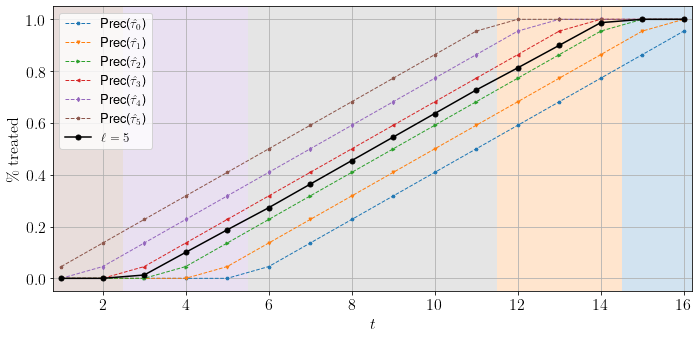

In [9]:
thres = 0.2
result_df = pd.DataFrame(result)
result_df['index'] = range(1, T+1)
result_df = result_df.set_index('index')
fig, ax = plt.subplots(figsize=(10,5))
markers = ['H', 'v', '>', '<', 'd', 'p', 'o']
for l in range(lag+1): 
    plt.plot(result_df["Prec($\\hat{\\tau}_"+str(l)+"$)"], marker=markers[l], linestyle='dashed', label="Prec($\\hat{\\tau}_"+str(l)+"$)", markersize=3,linewidth=1.)
plt.plot(result_df["$\ell="+str(l)+"$"], marker=markers[l+1], label="$\ell="+str(l)+"$", markersize=5,linewidth=1.5, color="black")
plt.xlabel("$t$"); plt.ylabel("$\%$ $\mathrm{treated}$");
plt.xlim([1-thres, T+thres])
plt.grid(True)
ax.axvspan(1-thres, int(lag/2)+0.5, alpha=0.2, facecolor='#8c564b')
ax.axvspan(int(lag/2)+0.5, lag+0.5, alpha=0.2, facecolor='#9467bd')
ax.axvspan(lag+0.5, T-lag+0.5, alpha=0.2, facecolor='#7f7f7f')
ax.axvspan(T-lag+0.5, T-int(lag/2)+0.5, alpha=0.2, facecolor='#ff7f0e')
ax.axvspan(T-int(lag/2)+0.5, T+thres, alpha=0.2, facecolor='#1f77b4')
plt.legend()
plt.tight_layout()
plt.savefig("../figures/carryover-t-optimal-s-curve.pdf")

carryover effect: optimize determinant

In [6]:
T = 10
result = dict(); result["$\ell="+str(0)+"$"] = [(2*t+1)/(2*T) for t in range(T)]
for lag in range(1, 6):
    def crossover_fun(y, L=lag):
        H = theta1(y,L=L) - theta2(y,L=L)
        return -np.linalg.det(H)

    y0 = [((2*t+1)/T-1) for t in range(T)]
    bnds = tuple([(-1,1) for t in range(T)])
    cons = tuple([{'type': 'ineq', 'fun' : lambda y: y[t]-y[t-1]} for t in range(1,T)])
    res = scipy.optimize.minimize(crossover_fun, y0, constraints=cons, bounds=bnds)
    result["$\ell="+str(lag)+"$"] = (1+res.x)/2

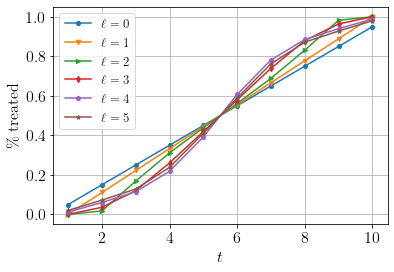

In [7]:
result_df = pd.DataFrame(result)
result_df['index'] = range(1, T+1)
result_df = result_df.set_index('index')
plt.figure()
markers = ['H', 'v', '>', 'd', 'p', '*']
for l in range(6): 
    plt.plot(result_df["$\ell="+str(l)+"$"], marker=markers[l], label="$\ell="+str(l)+"$", markersize=4.5)
plt.xlabel("$t$"); plt.ylabel("$\%$ $\mathrm{treated}$");
plt.grid(True)
plt.legend()
plt.savefig("../figures/carryover-d-optimal.pdf")